<a href="https://colab.research.google.com/github/francoishcm/BackTesting/blob/master/Momentum_Ranking_Model_revised3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install packages

In [ ]:
!pip install yfinance

In [ ]:
!pip install yahooquery

In [ ]:
!pip install stockstats

In [ ]:
!pip install mpld3

###Modules and settings

In [18]:
%matplotlib inline
import datetime
from datetime import date
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import mpld3
mpld3.enable_notebook()
"""
Settings
"""
portfolio_value = 156787.84
perf_last_month = 156787.84
start = "2020-01-01"
end = "2023-09-01"
ranking_day = "2023-08-29"
index_date = 'STXCAP29082023.csv'
ranking_table ="ranking_table290823.csv"
portfolio = "portfolio290823.csv"
current_portfolio = "portfolio_140723.csv"

# Storing today's date into a variable
today = date.today()
# Storing the specific date
trading_day = today
# Calculate percent difference since last month
perf_pct = (portfolio_value / perf_last_month) - 1
# Print performance, format as percent with two decimals.
print("{} - Last Month Result: {:.2%}".format(trading_day, perf_pct))
# Remember today's portfolio value for next month's calculation
#perf_last_month = portfolio_value

2023-08-29 - Last Month Result: 0.00%


###Import Market Data

             Close         SMA      diff
Date                                    
2023-08-29  3759.0  3808.92188 -49.92188
Exchange Name = Johannesburg Stock Exchange
PROSUS N.V.: PRX.XJSE
ANHEUSER-BUSCH INBEV SA NV: ANH.XJSE
BHP GROUP PLC: BHP.XJSE
BRITISH AMERICAN TOB PLC: BTI.XJSE
NASPERS LTD -N-: NPN.XJSE
COMPAGNIE FIN RICHEMONT: CFR.XJSE
GLENCORE PLC: GLN.XJSE
ANGLO AMERICAN PLC: AGL.XJSE
FIRSTRAND LTD: FSR.XJSE
ANGLO AMERICAN PLAT LTD: AMS.XJSE
STANDARD BANK GROUP LTD: SBK.XJSE
VODACOM GROUP LTD: VOD.XJSE
MONDI PLC: MNP.XJSE
CAPITEC BANK HLDGS LTD: CPI.XJSE
BEE - SASOL LIMITED: SOLBE1.XJSE
SANLAM LIMITED: SLM.XJSE
MTN GROUP LTD: MTN.XJSE
ANGLOGOLD ASHANTI LTD: ANG.XJSE
SASOL LIMITED: SOL.XJSE
ABSA GROUP LIMITED: ABG.XJSE
SOUTH32 LIMITED: S32.XJSE
RMB HOLDINGS LTD: RMH.XJSE
IMPALA PLATINUM HLGS LTD: IMP.XJSE
BID CORPORATION LTD: BID.XJSE
REMGRO LTD: REM.XJSE
KUMBA IRON ORE LTD: KIO.XJSE
NEDBANK GROUP LTD: NED.XJSE
SIBANYE STILLWATER LTD: SSW.XJSE
GOLD FIELDS LTD: GFI.XJSE
INVESTEC

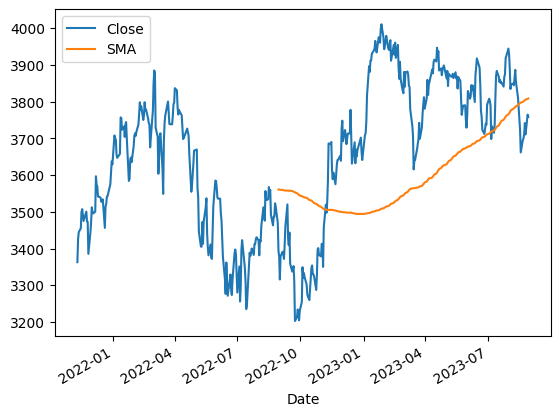

In [6]:
#Import required libraries
import pandas as pd
import json
import requests
import glob
import os
from yahooquery import Ticker
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d")
data = yf.Ticker("STXCAP.JO")
index = data.history(start=start,  end=end)
resetindex = index.reset_index(inplace = True)

index['Date'] = pd.to_datetime(index['Date']).dt.strftime('%Y-%m-%d')

index = index.drop(columns=(['Open', 'High','Low','Volume','Dividends','Stock Splits']))

index.set_index("Date", inplace=True)

index.to_csv(index_date)
STX = pd.read_csv(index_date,index_col='Date', parse_dates=['Date'])
STX['SMA'] = STX['Close'].rolling(200).mean()
STX.plot()
STX['diff'] = STX['Close'] - STX['SMA']
print(STX.tail(1))


params = {'access_key': 'e52cf3b93696352e880916f8c8adbf0c',
          'limit': 350}
api_result = requests.get('http://api.marketstack.com/v1/exchanges/XJSE/tickers', params)
api_response = api_result.json()
print(f"Exchange Name = {api_response['data']['name']}")
for ticker in api_response['data']['tickers']:
  print(f"{ticker['name']}: {ticker['symbol']}")


# Serializing json
json_object = json.dumps(api_response, indent=4)
# Writing to sample.json
with open("jse.json", "w") as outfile:
    outfile.write(json_object)

# Opening JSON file
with open('jse.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df1 = pd.json_normalize(json_object["data"]["tickers"])

# dropping null value columns to avoid errors
# new data frame with split value columns
new = df1["symbol"].str.split(".", n = 1, expand = True)
# making separate first name column from new data frame
df1["ticker"]= new[0]
# Dropping old Name columns
df1.drop(columns =["has_intraday","has_eod"], inplace = True)
new.columns = new.columns.astype(str)
new.columns.values[1] = "tickers"
new['0'] + '.' + new['tickers']
new.replace("XJSE", "JO", inplace=True)

result = pd.concat([df1, new], axis=1, join='inner')
df2=result['0'] + '.' + result['tickers']
final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)
#Dropping old Name columns
final.drop(columns =["name", "symbol","ticker"], inplace = True)
# Converting a specific Dataframe
# column to list using Series.tolist()
xjse = final["tickers"].tolist()
print("Converting tickers to list...")
print("Output dataframe..." )
print("Writing csv file..." )
print("Saving JSE data to disc...")
print("Saving csv files for each stock to disc...")
symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start= start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)


#Convert dataframe to csv and save to disc
final.to_csv("tickers.csv")
data.to_csv("jse_stocks.csv")

resetindex = data.reset_index(inplace = True)

for i, g in data.groupby('symbol'):
    g.to_csv('/content/Stocks/{}.csv'.format(i), header=True, index_label=False)

# merging the files
joined_files = os.path.join("/content/Stocks/", "*.csv")

# A list of all joined files is returned
joined_list = glob.glob(joined_files)

# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

# new dataframe with different column order
df_new = df.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.to_csv("/content/tickers.csv")

#Change date format to Year-Month-Day
df_new['date'] =  pd.to_datetime(df_new['date']).dt.strftime('%Y-%m-%d')

df_new.set_index('date', inplace=True)

for i, g in df_new.groupby('symbol'):
    g.to_csv('/content/Stocks_final3/{}.csv'.format(i), header=True, index_label=False)

symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start=start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)

resetindex = data.reset_index(inplace = True)

# new dataframe with different column order
df_new = data.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.columns = df.iloc[1]

df.to_csv("/content/Stocks_final3/tickers.csv")


csv_folder = Path('/content/Stocks_final3')

for file in csv_folder.glob('*.JO.csv'): #create iteratable & iterate on it.
    mydata = pd.read_csv(file)
    mydata.reset_index(inplace = True)
    mydata = mydata.rename(columns={'index': 'date'}, index=None)
    mydata['date'] =  pd.to_datetime(mydata['date']).dt.strftime('%Y-%m-%d')
    mydata.set_index('date', inplace=True)
    df =mydata[["open","high","low","close","volume"]]
    no_outlier_prices = df[(np.abs(stats.zscore(df)) <3).all(axis=1)]
    new_file_name = file.parent.joinpath(f"{file.stem}.csv")
    no_outlier_prices.to_csv(new_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

###Indicators

In [7]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from pathlib import Path
import pandas as pd
import stockstats
from stockstats import StockDataFrame as sdf
import glob

plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.ioff()

tickers = pd.read_csv('/content/Stocks_final3/tickers.csv', header=None)[1].tolist()
stocks = (
    (pd.concat(
        [pd.read_csv(f"/content/Stocks_final3/{ticker}.csv",parse_dates=None, index_col=0)[
        'close'].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)
stocks = stocks.loc[:,~stocks.columns.duplicated()]

from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

momentums = stocks.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)

result = momentums.sort_values(by =ranking_day, axis = 1, ascending =False)
result.reset_index(inplace=True)
res=result[~(result['date'] < ranking_day)].dropna(axis=1)

mes = res.reindex(columns = res.columns.tolist()
                                  + ['empty'])

df = mes.set_index(['empty']).stack().reset_index(name='index').rename(columns={'level_2':'date'})

df.columns = df.iloc[0]

df.index = list(df.index)

df.columns.values[0] = "empty"
df.columns.values[1] = "symbol"
df.columns.values[2] = "momentum_score"

df=df.drop(['empty'], axis=1)

finalframe=df.drop(index=0)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

finalframe['rank']=finalframe['momentum_score'].rank(ascending=False)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

#finalframe.style.format({'momentum_score':"{:.2f}"})

Mylist = finalframe["symbol"].tolist()

finalframe.set_index('symbol',inplace=True)

final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)

final.set_index('tickers', inplace=True)
Yes = final.reindex(Mylist)

rt = pd.concat([finalframe, Yes], axis=1, join='inner')

rt = rt.iloc[:, [2, 3, 4, 0, 1]]

#rt.style.format({'momentum_score':"{:.2f}"})

# get names of indexes for which column "momentum_score" has value > 40%
index_names = rt[(rt['momentum_score'] < 0.001)].index

# drop these given row indexes from dataFrame
rt.drop(index_names, inplace = True)

rt.reset_index(inplace=True)

lowranked = rt [( rt ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
rt.drop( lowranked, inplace = True)

My_final_list = rt["index"].tolist()

rt.set_index('index',inplace=True)

rt.to_csv(ranking_table)
final_table_columns = My_final_list
final_table =stocks.drop(columns=[col for col in stocks if col not in final_table_columns])

for column in final_table.columns:
    final_table[column].to_csv('/content/momentum_tickers/' + column + '.csv')

vola_table = Path('/content/momentum_tickers')

for file in vola_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df = pd.read_csv(file)
    vola_df.columns.values[1] = "close"
    vola_df["20d_vol"] = vola_df["close"].pct_change().rolling(20).std()
    #vola_df = sdf.retype(vola_df)['close_90_roc']
    #vola_df = pd.DataFrame(vola_df)
    vola_df['date'] =  pd.to_datetime(vola_df['date']).dt.strftime('%Y-%m-%d')
    vola_df.set_index('date', inplace=True)
    stockstats_df = sdf.retype(vola_df)['close_90_roc']
    df = pd.DataFrame(stockstats_df)
    vola_file_name= file.parent.joinpath(f"/content/ranking_table/{file.stem}.csv")
    vola_df.to_csv(vola_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

vola_table1 = Path('/content/ranking_table')

for file in vola_table1.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df1 = pd.read_csv(file).tail(1)

    vola_df1['date'] =  pd.to_datetime(vola_df1['date']).dt.strftime('%Y-%m-%d')

    vola_df1.set_index('date', inplace=True)

    vola_file_name1= file.parent.joinpath(f"/content/momentum_stocks/{file.stem}.csv")

    vola_df1.to_csv(vola_file_name1)


# set search path and glob for files
# here we want to look for csv files in the input directory
path = '/content/'
files = glob.glob(path + '/momentum_stocks/*.csv')

# create empty list to store dataframes
li = []

# loop through list of files and read each one into a dataframe and append to list
for f in files:
    # get filename
    stock = os.path.basename(f)
    # read in csv
    temp_df = pd.read_csv(f)
    # create new column with filename
    temp_df['ticker'] = stock
    # data cleaning to remove the .csv
    temp_df['ticker'] = temp_df['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li.append(temp_df)
    #print(f'Successfully created dataframe for {stock} with shape {temp_df.shape}')

# concatenate our list of dataframes into one!
df = pd.concat(li)

ranking_list =df.set_index('ticker').reindex(My_final_list).reset_index()

inv_vol = 1 / ranking_list["20d_vol"]
sum_inv_vol=inv_vol.sum()
vol_targets = inv_vol / sum_inv_vol
ranking_list["weight"] = vol_targets

ranking_list.set_index('ticker', inplace=True)

final_list = pd.concat([rt,ranking_list], axis=1, join='inner')

stockprice = final_list["close"] / 100
pos_weight = portfolio_value * final_list["weight"]
final_list["units"] = pos_weight / stockprice
final_list["ZAR"] = stockprice * final_list["units"]


sma = Path('/content/ranking_table')

for file in sma.glob('*.JO.csv'): #create iteratable & iterate on it.
    sma = pd.read_csv(file)
    sma['date'] =  pd.to_datetime(sma['date']).dt.strftime('%Y-%m-%d')
    sma.set_index('date', inplace=True)

    '''Function'''

    sma['100d_sma'] = sma['close'].rolling(100).mean()

    #sma['index_sma']=index['Close'].rolling(200).mean()

    #sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index'] = index['Close']

    sma['index_sma']=index['Close'].rolling(200).mean()

    sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index_trend']= np.where(sma['index'] > sma['index_sma'], True, False)

    sma_file_name= file.parent.joinpath(f"/content/sma_data/{file.stem}.csv")

    sma.to_csv(sma_file_name)

buy_table = Path('/content/sma_data')

for file in buy_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    buy_list_df = pd.read_csv(file).tail(1)

    buytable = file.parent.joinpath(f"/content/buy_list/{file.stem}.csv")

    buy_list_df.to_csv(buytable)

###Initial Portfolio and Ranking Table

In [8]:
import pandas as pd
import glob

# set search path and glob for files
# here we want to look for csv files in the input directory
path1 = '/content/'
files1 = glob.glob(path1 + '/buy_list/*.csv')

# create empty list to store dataframes
li1 = []

# loop through list of files and read each one into a dataframe and append to list
for f1 in files1:
    # get filename
    stock1 = os.path.basename(f1)
    # read in csv
    temp_df1 = pd.read_csv(f1)
    # create new column with filename
    temp_df1['ticker'] = stock1
    # data cleaning to remove the .csv
    temp_df1['ticker'] = temp_df1['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li1.append(temp_df1)
    #print(f'Successfully created dataframe for {stock1} with shape {temp_df1.shape}')

# concatenate our list of dataframes into one!
Buy = pd.concat(li1)

buying_list = Buy.set_index('ticker').reindex(My_final_list)#.reset_index()

final_buy_list = pd.concat([final_list, buying_list], axis=1, join='inner')

#define list of columns range
cols = [x for x in range(final_buy_list.shape[1])]

#remove second column in DataFrame
cols.remove(12)
cols.remove(13)
cols.remove(14)
cols.remove(15)
cols.remove(16)#view resulting DataFrame
final_buy_list2 =final_buy_list.iloc[:, cols]
final_buy_list2.info()

final_buy_list2 = final_buy_list2.loc[final_buy_list2.trend, :]

index_names1 = final_buy_list2[(final_buy_list2['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
final_buy_list2.drop(index_names1, inplace = True)
final_buy_list2.to_csv(portfolio)
final_buy_list2

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, TLM.JO to CSB.JO
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            70 non-null     object 
 1   symbol          70 non-null     object 
 2   ticker          70 non-null     object 
 3   momentum_score  70 non-null     float64
 4   rank            70 non-null     float64
 5   date            70 non-null     object 
 6   close           70 non-null     float64
 7   20d_vol         70 non-null     float64
 8   close_90_roc    69 non-null     float64
 9   weight          70 non-null     float64
 10  units           70 non-null     float64
 11  ZAR             70 non-null     float64
 12  100d_sma        61 non-null     float64
 13  index           70 non-null     float64
 14  index_sma       70 non-null     float64
 15  trend           70 non-null     bool   
 16  index_trend     70 non-null     bool   
dtypes: bool(2), float64(11), object(4

,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
GLI.JO,GO LIFE INTERNATIONAL LD,GLI.XJSE,GLI,2.349074,3.0,2023-08-29,1.0,0.255209,0.000000,0.001186,18599.190436,185.991904,0.8231,3759.0,3808.92188,True,False
TXT.JO,TEXTAINER GROUP HLDGS LTD,TXT.XJSE,TXT,1.158701,5.0,2023-08-29,73177.0,0.021904,9.710645,0.013822,2.961416,2167.075728,71317.1000,3759.0,3808.92188,True,False
SPG.JO,SUPER GROUP LTD,SPG.XJSE,SPG,1.155566,6.0,2023-08-29,3460.0,0.017817,8.226462,0.016992,76.996895,2664.092574,3241.2500,3759.0,3808.92188,True,False
QFH.JO,QUANTUM FOODS HLDGS LTD,QFH.XJSE,QFH,1.080770,7.0,2023-08-29,485.0,0.009885,9.977324,0.030627,990.099499,4801.982568,461.6500,3759.0,3808.92188,True,False
ART.JO,ARGENT INDUSTRIAL LTD,ART.XJSE,ART,0.833925,11.0,2023-08-29,1555.0,0.016119,6.799451,0.018782,189.377653,2944.822512,1533.2500,3759.0,3808.92188,True,False
MTH.JO,MOTUS HOLDINGS LTD,MTH.XJSE,MTH,0.833385,12.0,2023-08-29,10590.0,0.022378,10.312500,0.013529,20.029368,2121.110089,9757.3800,3759.0,3808.92188,True,False
CML.JO,CORONATION FUND MNGRS LD,CML.XJSE,CML,0.769543,14.0,2023-08-29,3235.0,0.009263,10.334243,0.032682,158.394828,5124.072676,3167.0500,3759.0,3808.92188,True,False
INL.JO,INVESTEC LTD,INL.XJSE,INL,0.757200,15.0,2023-08-29,10872.0,0.014619,10.386841,0.020708,29.864087,3246.823494,10574.2200,3759.0,3808.92188,True,False
CLI.JO,CLIENTELE LTD,CLI.XJSE,CLI,0.754481,16.0,2023-08-29,1116.0,0.029167,6.387035,0.010380,145.825029,1627.407326,1083.4600,3759.0,3808.92188,True,False
ABG.JO,ABSA GROUP LIMITED,ABG.XJSE,ABG,0.732318,17.0,2023-08-29,18530.0,0.017575,5.218329,0.017226,14.575134,2700.772379,17217.7600,3759.0,3808.92188,True,False


###List to Liquidate current positions

In [ ]:

sell_list = final_buy_list [~final_buy_list
 ["trend"]]
#sell_list.info()
dqs = sell_list ["ticker"].tolist()
cpf=pd.read_csv(current_portfolio)
#sell_list
liquidate = cpf.loc[cpf['ticker'].isin (dqs)].reset_index (drop=True)

newpf = cpf[~cpf['ticker'].isin(liquidate['ticker'])]
dfnew = newpf[~newpf['ticker'].isin(final_buy_list2['ticker'])]

remove = dfnew ["ticker"].tolist()
now = newpf[~newpf['ticker'].isin(dfnew['ticker'])]
now.set_index("ticker", inplace=True)
rebalance = now ["symbol"].tolist()

print(f"Liquidate disqualified stocks = {liquidate['name']}")
print(f"Liquidate stocks not in ranking table= {dfnew['name']}")
print(f"Portfolio after liquidation= {now['name']}")

Liquidate disqualified stocks = 0                 TRENCOR LTD
1         PEPKOR HOLDINGS LTD
2       HUDACO INDUSTRIES LTD
3    JUBILEE METALS GROUP PLC
4                 PROSUS N.V.
Name: name, dtype: object
Liquidate stocks not in ranking table= 0                  VUNANI LTD
1         SEBATA HOLDINGS LTD
5                  REMGRO LTD
7                 REUNERT LTD
13       SPUR CORPORATION LTD
15    4Sight Holdings Limited
17         NU-WORLD HLDGS LTD
18           RAUBEX GROUP LTD
19       DISCOVERY LTD B PREF
20     METROFILE HOLDINGS LTD
22                BIDVEST LTD
25          ENX GROUP LIMITED
26             SANTAM LIMITED
Name: name, dtype: object
Portfolio after liquidation= ticker
SRE        SIRIUS REAL ESTATE LTD
ART         ARGENT INDUSTRIAL LTD
LHC    LIFE HEALTHC GRP HLDGS LTD
ABG            ABSA GROUP LIMITED
ASC           ASCENDIS HEALTH LTD
CLI                 CLIENTELE LTD
QFH       QUANTUM FOODS HLDGS LTD
SPG               SUPER GROUP LTD
MTM        MOMENTUM MET HLDGS

###Update Ranking Table

In [39]:
portfolio_value2=129286.63

final_weights = final_buy_list
final_weights.set_index('rank').reset_index()
final_w = [x for x in range(final_weights.shape[1])]

final_w.remove(12)
final_w.remove(13)
final_w.remove(14)
final_w.remove(15)
final_w.remove(16)
final_weights2=final_weights.iloc[:, cols]
inv_vol2 = 1 / final_weights2["20d_vol"]
sum_inv_vol2 =inv_vol2.sum()
vol_targets2 = inv_vol2 / sum_inv_vol2
final_weights2["weight"] = vol_targets2

final_weights2.set_index('symbol', inplace=True)

stockprice2 = final_weights2["close"] / 100
pos_weight2 = portfolio_value2 * final_weights2["weight"]
final_weights2["units"] = pos_weight2 / stockprice2
final_weights2["ZAR"] = stockprice2 * final_weights2["units"]
final_weights2.to_csv(ranking_table)

final_weights2


<ipython-input-39-a784903a1911>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["weight"] = vol_targets2
<ipython-input-39-a784903a1911>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["units"] = pos_weight2 / stockprice2
<ipython-input-39-a784903a1911>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,name,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
symbol,,,,,,,,,,,,,,,,
TLM.XJSE,TELEMASTER HOLDINGS LTD,TLM,119.321575,1.0,2023-08-29,110.0,22.149720,29.411765,0.000014,1.606461,1.767107,79.8695,3759.0,3808.92188,True,False
OAO.XJSE,OANDO PLC,OAO,3.334711,2.0,2023-08-29,25.0,0.294769,19.047619,0.001027,531.140741,132.785185,14.7924,3759.0,3808.92188,True,False
GLI.XJSE,GO LIFE INTERNATIONAL LD,GLI,2.349074,3.0,2023-08-29,1.0,0.255209,0.000000,0.001186,15336.818546,153.368185,0.8231,3759.0,3808.92188,True,False
TRU.XJSE,TRUWORTHS INT LTD,TRU,2.301490,4.0,2023-08-29,7134.0,0.013953,32.380776,0.021697,39.321444,2805.191806,5762.1600,3759.0,3808.92188,True,False
TXT.XJSE,TEXTAINER GROUP HLDGS LTD,TXT,1.158701,5.0,2023-08-29,73177.0,0.021904,9.710645,0.013822,2.441972,1786.962036,71317.1000,3759.0,3808.92188,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HDC.XJSE,HUDACO INDUSTRIES LTD,HDC,0.161971,66.0,2023-08-29,15400.0,0.019088,0.000000,0.015861,13.315408,2050.572755,15477.7500,3759.0,3808.92188,False,False
RCL.XJSE,RCL FOODS LIMITED,RCL,0.147784,67.0,2023-08-29,1100.0,0.029415,-5.008636,0.010292,120.967319,1330.640514,NaN,3759.0,3808.92188,False,False
TRE.XJSE,TRENCOR LTD,TRE,0.136595,68.0,2023-08-29,661.0,0.032991,4.588608,0.009177,179.489141,1186.423219,659.4900,3759.0,3808.92188,True,False


In [37]:
ticker

yfinance.Ticker object <INPR.JO>

In [ ]:
todays_ranking_table = pd.read_csv("/content/ranking_table290823.csv")
todays_ranking_table

###Rebalance Positions

In [ ]:
rebalance1 =final_weights2[final_weights2['name'].isin(now['name'])]

index_names4 = rebalance1 [( rebalance1 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
Allsale =rebalance1.drop(index_names4)

rebalance3 = rebalance1.reindex(rebalance).set_index('ticker')


now.reset_index(inplace=True)
rebalance3.reset_index(inplace=True)

rebalance3 ["bs"] = rebalance3["units"]-now["units"]
index_names5 = rebalance3 [( rebalance3 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
rebalance3.drop(index_names5, inplace = True)
rebalance3

,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,bs
0,SRE,SIRIUS REAL ESTATE LTD,0.314125,30.0,2023-08-23,1935.0,0.013488,10.068259,0.021140,175.350446,3393.031124,1925.14,74022.578125,76368.594883,True,False,174.062970
1,ART,ARGENT INDUSTRIAL LTD,0.922613,6.0,2023-08-23,1570.0,0.016539,6.802721,0.017240,176.248020,2767.093906,1529.39,74022.578125,76368.594883,True,False,173.870375
2,LHC,LIFE HEALTHC GRP HLDGS LTD,0.068753,61.0,2023-08-23,2048.0,0.012266,5.458290,0.023246,182.176380,3730.972266,2025.28,74022.578125,76368.594883,True,False,179.833134
3,ABG,ABSA GROUP LIMITED,0.349355,24.0,2023-08-23,18273.0,0.017633,-1.243042,0.016171,14.203978,2595.492849,17207.34,74022.578125,76368.594883,True,False,13.985873
4,ASC,ASCENDIS HEALTH LTD,0.022665,67.0,2023-08-23,63.0,0.032527,1.612903,0.008766,2233.349443,1407.010149,62.87,74022.578125,76368.594883,True,False,2208.270741
5,CLI,CLIENTELE LTD,0.772767,10.0,2023-08-23,1140.0,0.029189,8.571429,0.009769,137.535161,1567.900839,1079.18,74022.578125,76368.594883,True,False,136.780709
6,QFH,QUANTUM FOODS HLDGS LTD,1.081738,3.0,2023-08-23,485.0,0.010153,12.529002,0.028085,929.402968,4507.604395,460.27,74022.578125,76368.594883,True,False,925.803941
7,SPG,SUPER GROUP LTD,0.954451,5.0,2023-08-23,3505.0,0.019514,8.986318,0.014612,66.912906,2345.297340,3234.17,74022.578125,76368.594883,True,False,65.383869
8,MTM,MOMENTUM MET HLDGS LTD,0.475684,16.0,2023-08-23,1928.0,0.013641,5.643836,0.020904,174.019233,3355.090815,1818.96,74022.578125,76368.594883,True,False,171.917563


###Enter New Positions

In [ ]:
ranking_table1 = final_weights2.reindex().set_index('ticker')
#ranking_table1["bs"] = ranking_table1["units"] * 1
ranking_table1.reset_index(inplace=True)

ranking_table1 = ranking_table1.loc[ranking_table1.trend, :]
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

buynew = ranking_table1 [~ ranking_table1 ['ticker'].isin( rebalance3 ['ticker'])]
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

buynamesnew2 = buynew [( buynew ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
buynew.drop( buynamesnew2, inplace = True)

buynew

<ipython-input-61-02273f304f57>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buynew.drop( buynamesnew2, inplace = True)


,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
6,CML,CORONATION FUND MNGRS LD,0.902613,7.0,2023-08-23,3204.0,0.013260,5.187131,0.021504,107.720103,3451.352094,3159.7900,74022.578125,76368.594883,True,False
7,INL,INVESTEC LTD,0.870785,8.0,2023-08-23,10817.0,0.014326,9.717010,0.019904,29.533139,3194.599637,10533.2000,74022.578125,76368.594883,True,False
8,INP,INVESTEC PLC,0.812591,9.0,2023-08-23,10900.0,0.013219,9.218437,0.021570,31.761524,3462.006135,10621.2600,74022.578125,76368.594883,True,False
11,MTH,MOTUS HOLDINGS LTD,0.696434,12.0,2023-08-23,10112.0,0.024584,5.829409,0.011599,18.409873,1861.606396,9732.6200,74022.578125,76368.594883,True,False
33,VKE,VUKILE PROPERTY FUND LTD,0.278954,34.0,2023-08-23,1305.0,0.012725,0.772201,0.022408,275.590579,3596.457054,1271.4800,74022.578125,76368.594883,True,False
44,JSE,JSE LTD,0.204050,45.0,2023-08-23,9727.0,0.017116,-1.925791,0.016660,27.489008,2673.855810,9367.9000,74022.578125,76368.594883,True,False
48,SYG,SYGNIA LIMITED,0.179290,49.0,2023-08-23,1770.0,0.030316,2.017291,0.009406,85.289132,1509.617634,1727.6500,74022.578125,76368.594883,True,False
51,MPT,MPACT LIMITED,0.155712,52.0,2023-08-23,3050.0,0.018752,8.540925,0.015206,80.020468,2440.624282,2700.9900,74022.578125,76368.594883,True,False
54,MTNZF,MTN ZAKHELE FUTHI,0.143076,55.0,2023-08-23,2100.0,0.032420,10.410095,0.008795,67.222621,1411.675046,1914.6600,74022.578125,76368.594883,True,False
57,LAB,LABAT AFRICA LTD,0.096234,58.0,2023-08-23,8.0,0.114660,0.000000,0.002487,4989.325750,399.146060,7.7300,74022.578125,76368.594883,True,False


###Portfolio after position rebalance

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rebalancex = rebalance3.reset_index().set_index("level_0")
buynewx = buynew.reset_index().set_index("level_0")
new_portfolio2 = rebalancex.append(buynewx, ignore_index=True)
new_portfolio2.drop(columns =["bs"], inplace = True)
rslt_df = new_portfolio2.sort_values(by = 'rank', ascending = True)
rslt_df .ticker = rslt_df.ticker+ '.JO'
Tickers = rslt_df["ticker"].tolist()
sector_list=[]

for tik in Tickers:
    ticker=yf.Ticker(tik)
    sector=ticker.info['sector']
    sector_list.append(sector)

rslt_df ['sector'] = sector_list
rslt_df

<ipython-input-71-5be5fbafb8f0>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_portfolio2 = rebalancex.append(buynewx, ignore_index=True)


,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,sector
6,QFH.JO,QUANTUM FOODS HLDGS LTD,1.081738,3.0,2023-08-23,485.0,0.010153,12.529002,0.028085,929.402968,4507.604395,460.2700,74022.578125,76368.594883,True,False,Consumer Defensive
7,SPG.JO,SUPER GROUP LTD,0.954451,5.0,2023-08-23,3505.0,0.019514,8.986318,0.014612,66.912906,2345.297340,3234.1700,74022.578125,76368.594883,True,False,Industrials
1,ART.JO,ARGENT INDUSTRIAL LTD,0.922613,6.0,2023-08-23,1570.0,0.016539,6.802721,0.017240,176.248020,2767.093906,1529.3900,74022.578125,76368.594883,True,False,Basic Materials
9,CML.JO,CORONATION FUND MNGRS LD,0.902613,7.0,2023-08-23,3204.0,0.013260,5.187131,0.021504,107.720103,3451.352094,3159.7900,74022.578125,76368.594883,True,False,Financial Services
10,INL.JO,INVESTEC LTD,0.870785,8.0,2023-08-23,10817.0,0.014326,9.717010,0.019904,29.533139,3194.599637,10533.2000,74022.578125,76368.594883,True,False,Financial Services
11,INP.JO,INVESTEC PLC,0.812591,9.0,2023-08-23,10900.0,0.013219,9.218437,0.021570,31.761524,3462.006135,10621.2600,74022.578125,76368.594883,True,False,Financial Services
5,CLI.JO,CLIENTELE LTD,0.772767,10.0,2023-08-23,1140.0,0.029189,8.571429,0.009769,137.535161,1567.900839,1079.1800,74022.578125,76368.594883,True,False,Financial Services
12,MTH.JO,MOTUS HOLDINGS LTD,0.696434,12.0,2023-08-23,10112.0,0.024584,5.829409,0.011599,18.409873,1861.606396,9732.6200,74022.578125,76368.594883,True,False,Consumer Cyclical
8,MTM.JO,MOMENTUM MET HLDGS LTD,0.475684,16.0,2023-08-23,1928.0,0.013641,5.643836,0.020904,174.019233,3355.090815,1818.9600,74022.578125,76368.594883,True,False,Financial Services
3,ABG.JO,ABSA GROUP LIMITED,0.349355,24.0,2023-08-23,18273.0,0.017633,-1.243042,0.016171,14.203978,2595.492849,17207.3400,74022.578125,76368.594883,True,False,Financial Services


###Portfolio after rebalance

In [ ]:

Xxx = final_buy_list2[final_buy_list2['name'].isin(now['name'])]
Xxx2 = Xxx.reset_index().set_index("level_0")
buynewx = buynew.reset_index().set_index("level_0")
new_portfolio3 = Xxx2.append(buynewx, ignore_index=True)
rslt_df2 = new_portfolio3.sort_values(by = 'rank', ascending = True)
inv_vol = 1 / rslt_df2["20d_vol"]
rslt_df2["weight"] = rslt_df2 ["ZAR"] / portfolio_value2
rslt_df2.set_index('rank', inplace=True)
rslt_df2.drop(columns =["symbol"], inplace = True)
rslt_df2 .ticker = rslt_df2.ticker+ '.JO'
Tickers = rslt_df2["ticker"].tolist()
sector_list=[]

for tik in Tickers:
    ticker=yf.Ticker(tik)
    sector=ticker.info['sector']
    sector_list.append(sector)

rslt_df2 ['sector'] = sector_list
rslt_df2

<ipython-input-64-1f4ed2583bbd>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_portfolio3 = Xxx2.append(buynewx, ignore_index=True)


,name,ticker,momentum_score,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,sector
rank,,,,,,,,,,,,,,,,
3.0,QUANTUM FOODS HLDGS LTD,QFH.JO,1.081738,2023-08-23,485.0,0.010153,12.529002,0.027435,907.907064,4403.349263,460.2700,74022.578125,76368.594883,True,False,Consumer Defensive
5.0,SUPER GROUP LTD,SPG.JO,0.954451,2023-08-23,3505.0,0.019514,8.986318,0.014274,65.365296,2291.053608,3234.1700,74022.578125,76368.594883,True,False,Industrials
6.0,ARGENT INDUSTRIAL LTD,ART.JO,0.922613,2023-08-23,1570.0,0.016539,6.802721,0.016842,172.171628,2703.094558,1529.3900,74022.578125,76368.594883,True,False,Basic Materials
7.0,CORONATION FUND MNGRS LD,CML.JO,0.902613,2023-08-23,3204.0,0.013260,5.187131,0.021504,107.720103,3451.352094,3159.7900,74022.578125,76368.594883,True,False,Financial Services
8.0,INVESTEC LTD,INL.JO,0.870785,2023-08-23,10817.0,0.014326,9.717010,0.019904,29.533139,3194.599637,10533.2000,74022.578125,76368.594883,True,False,Financial Services
9.0,INVESTEC PLC,INP.JO,0.812591,2023-08-23,10900.0,0.013219,9.218437,0.021570,31.761524,3462.006135,10621.2600,74022.578125,76368.594883,True,False,Financial Services
10.0,CLIENTELE LTD,CLI.JO,0.772767,2023-08-23,1140.0,0.029189,8.571429,0.009543,134.354149,1531.637295,1079.1800,74022.578125,76368.594883,True,False,Financial Services
12.0,MOTUS HOLDINGS LTD,MTH.JO,0.696434,2023-08-23,10112.0,0.024584,5.829409,0.011599,18.409873,1861.606396,9732.6200,74022.578125,76368.594883,True,False,Consumer Cyclical
16.0,MOMENTUM MET HLDGS LTD,MTM.JO,0.475684,2023-08-23,1928.0,0.013641,5.643836,0.020421,169.994391,3277.491849,1818.9600,74022.578125,76368.594883,True,False,Financial Services


###Test

<Axes: >

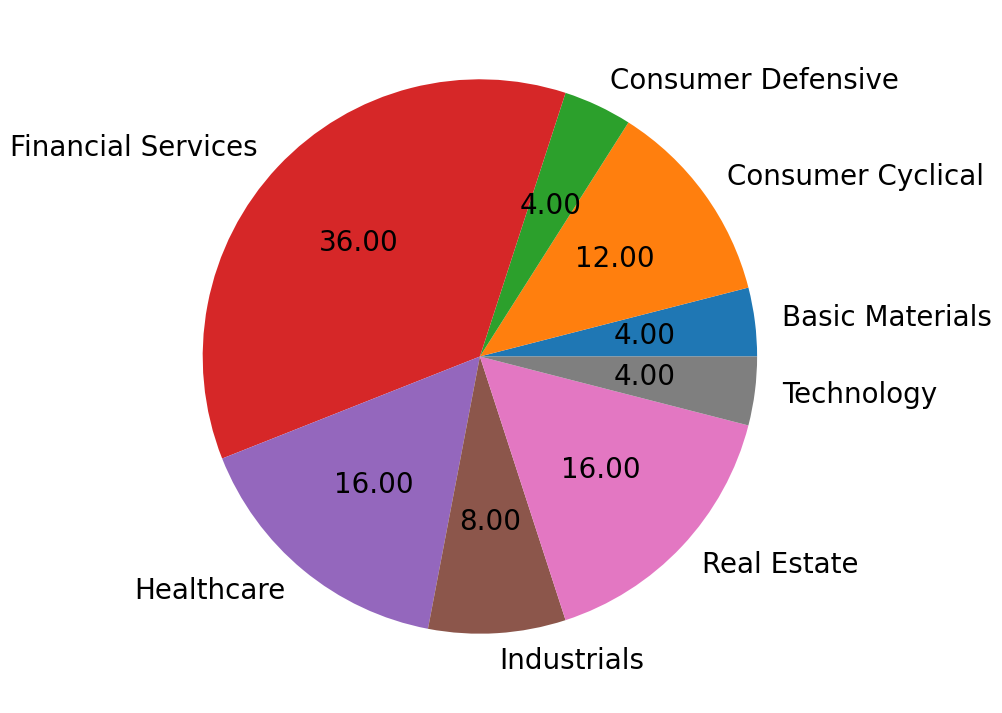

In [ ]:
from matplotlib.pyplot import pie, axis, show

rslt_df.groupby('sector').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20})